# Classifiying areas of work 

In [261]:
import itertools
import logging
import random
import sys
import time
from urllib.parse import quote_plus, urlparse
import itertools
import gensim

import os
import openpyxl

import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup

logging.basicConfig(
    level=logging.DEBUG,
    format="{asctime} {levelname}: {funcName} - {message}",
    style="{",
    datefmt="%Y-%m-%d %H:%M:%S",
    handlers=[logging.StreamHandler(sys.stdout)],
)

In [262]:
#topic modelling of keywords according to the three domains
#for each set of keywords I need to produce the dictionary with the probabilities 

#Compose training data 
input_file = os.path.join(os.getcwd(),'Hackathon_Market research_keywords.xlsx')

df_DS_keywords = pd.read_excel(input_file,'DS')
df_DS_keywords.replace({np.nan: ""}, inplace=True)

df_DP_keywords = pd.read_excel(input_file,'DP') 
df_DP_keywords.replace({np.nan: ""}, inplace=True)

df_AD_keywords = pd.read_excel(input_file,'AD')
df_AD_keywords.replace({np.nan: ""}, inplace=True)

df_DS_keywords["group"] = "DS"
df_DP_keywords["group"] = "DP"
df_AD_keywords["group"] = "AD"

all_kw = {'DS':set(),
          'DP':set(),
          'AD':set()}

lst_all = list()
for _, x in itertools.chain(
    df_DS_keywords.iterrows(), df_DP_keywords.iterrows(), df_AD_keywords.iterrows()
):
    tmp = x.to_dict()
    all_kw[tmp['group']].add(tmp["keyword"])
    all_kw[tmp['group']].update([y.strip() for y in tmp["synonyms"].split(",") if y.strip()])
    all_kw[tmp['group']].update([y.strip() for y in tmp["hyponyms"].split(",") if y.strip()])
    """
    lst_all.append(
        dict(
            keyword=tmp["keyword"],
            synonyms=[y.strip() for y in tmp["synonyms"].split(",") if y.strip()],
            hyponyms=[y.strip() for y in tmp["hyponyms"].split(",") if y.strip()],
            group=tmp["group"],
        )
    )
    """

DS_training = pd.DataFrame(all_kw['DS'])
DS_training['label'] = 'DS'

DP_training = pd.DataFrame(all_kw['DP'])
DP_training['label'] = 'DP'

AD_training = pd.DataFrame(all_kw['AD'])
AD_training['label'] = 'AD'


training_data = pd.concat([DS_training, DP_training, AD_training], axis=0)
training_data.rename(columns={0:'keyword'}, inplace=True) #where keyword can be also synonym or hyponim
training_data

,keyword,label
0,technical development,DS
1,animal cell culture,DS
2,stability studies,DS
3,research and development,DS
4,thermal stability,DS
...,...,...
56,reagents qualification,AD
57,microbial analytical capability,AD
58,cGMP,AD
59,photostability study,AD


Keywords with more than one area of work are ['stability studies', 'contract development', 'forced degradation', 'solubility enhancement', 'new chemical entities', 'stability testing', 'stability indicating methods', 'new chemical entity', 'stability study', 'development', 'non-GMP', 'clinical supply', 'GMP', 'cGMP', 'commercialization', 'pharma product testing']


<AxesSubplot:xlabel='label', ylabel='count'>

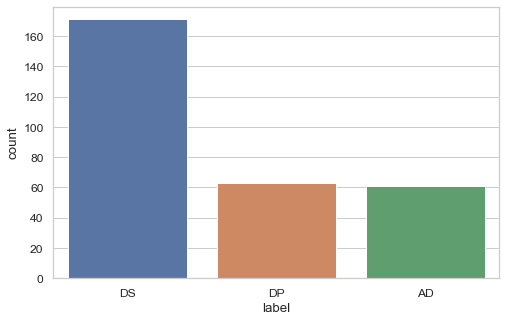

In [263]:
#just to have an understanding of the training data: 
# -- the same keyword can be associated to more than one area of work 
# -- more keywords for the AD area of work 

from collections import Counter
duplicates = [k for k,v in Counter(training_data['keyword']).items() if v>1]
print('Keywords with more than one area of work are {}'.format(duplicates))

#check distribution of labels 
import seaborn as sns
sns.countplot(x="label", data=training_data)

In [264]:
#filter the keywords keeping only those present among the given keywords
#and store in a new column the keywords to be kept for validation: either not given or not mapped in the training data  

keywords = pd.read_csv("extracted_keywords.csv")

given_keywords = pd.read_csv("known_keywords.csv")
given_keywords = [k.strip(' ') for k in list(given_keywords['keyword'])]
mapped_keywords = set(training_data['keyword'])


def not_mapped(ls, mapped_keywords):
    #storing keywords that are not given or not mapped for validation
    not_in_training = [e for e in ls if not (e in mapped_keywords)]
    return not_in_training

def given_and_mapped(ls,given_keywords,mapped_keywords):
    #storing keywords that are not given for validation
    flt_lst = [e for e in ls if e in given_keywords and e in mapped_keywords]
    return flt_lst


#turn the string into actual lst and filter only for the keywords for which we have a label  
#storing those that are not given for validation 

keywords['not_mapped'] = ''

for i in range(len(keywords['keywords'])):
    #turn the string into actual lst
    lst = keywords['keywords'][i].replace('\'','').replace('[','').replace(']','').split(',')
    lst = [k.strip(' ') for k in lst]
    #substitute the original list
    keywords['keywords'][i] = given_and_mapped(lst,given_keywords,mapped_keywords)
    #store the not mapped keywords 
    keywords['not_mapped'][i] = not_mapped(lst,mapped_keywords) 

keywords

,domain,keywords,company_name,not_mapped
0,https://1library.net,"[research and development, quality assurance, ...",1library,"[gdp, api]"
1,https://3pbio.com,"[recombinant proteins, clinical manufacturing,...",3pbio,"[gmp, cgmp]"
2,https://908devices.com,"[capillary electrophoresis, mammalian cell cul...",908devices,[ms]
3,https://99bitcoins.com,"[solution, research, development, tested, scal...",99bitcoins,"[cex, ad, sec]"
4,https://abzena.com,"[cell line development, mammalian cell culture...",Abzena,[]
...,...,...,...,...
458,https://www.xell.ag,"[cell line development, mammalian cell culture...",Xell,[]
459,https://www.yourway.com,"[clinical trial, clinical supply, clinical, re...",Yourway,"[gmp, gdp, ice]"
460,https://www.zellebiotech.com,"[cell line development, monoclonal antibody, q...",Zellebiotech,[elisa]
461,https://youteam.io,"[research and development, development, soluti...",Youteam,"[r&d, gdp, qa, ice]"


In [246]:
#keywords.iloc[0]['keywords'].append('GMP') #testing the case where the same keyword is associated to more than one area 
#keywords['keywords'][0]

In [265]:
#Simple classifier: takes the probability of appearance of a certain area of work 
keywords['mapping_area'] = ''

#mapping each keyword
for i in range(len(keywords['keywords'])):
    labels_dict = {el: training_data.loc[training_data['keyword'] == el]['label'].values.tolist() for el in keywords['keywords'][i]}
    keywords['mapping_area'][i] = labels_dict


#producing the output with the area of work (dictionary with the probabilities)
occurrences = []
for i in range(len(keywords['keywords'])):
    lbls = [keywords['mapping_area'][i][el] for el in keywords['mapping_area'][i]]
    #print(lbls)
    coefficients = [1/len(keywords['mapping_area'][i][el]) for el in keywords['mapping_area'][i]]
    #print(coefficients)
    output_dict = {'DP':[],'DS':[],'AD':[]}
    for lb in lbls: 
        cnt_DP = lb.count('DP')/len(lb)
        cnt_DS = lb.count('DS')/len(lb)
        cnt_AD = lb.count('AD')/len(lb)
        output_dict['DP'].append(cnt_DP)
        output_dict['DS'].append(cnt_DS)
        output_dict['AD'].append(cnt_AD)
    
    occurrences.append(output_dict)
    
for e in occurrences: 
    for k in e: 
        e[k]=round(sum(e[k])/len(e[k]),4)

    
keywords['prediction'] = occurrences
keywords

,domain,keywords,company_name,not_mapped,mapping_area,prediction
0,https://1library.net,"[research and development, quality assurance, ...",1library,"[gdp, api]","{'research and development': ['DS'], 'quality ...","{'DP': 0.3462, 'DS': 0.5769, 'AD': 0.0769}"
1,https://3pbio.com,"[recombinant proteins, clinical manufacturing,...",3pbio,"[gmp, cgmp]","{'recombinant proteins': ['DS'], 'clinical man...","{'DP': 0.1818, 'DS': 0.8182, 'AD': 0.0}"
2,https://908devices.com,"[capillary electrophoresis, mammalian cell cul...",908devices,[ms],"{'capillary electrophoresis': ['AD'], 'mammali...","{'DP': 0.1154, 'DS': 0.6538, 'AD': 0.2308}"
3,https://99bitcoins.com,"[solution, research, development, tested, scal...",99bitcoins,"[cex, ad, sec]","{'solution': ['DP'], 'research': ['DS'], 'deve...","{'DP': 0.4167, 'DS': 0.5833, 'AD': 0.0}"
4,https://abzena.com,"[cell line development, mammalian cell culture...",Abzena,[],"{'cell line development': ['DS'], 'mammalian c...","{'DP': 0.0667, 'DS': 0.9333, 'AD': 0.0}"
...,...,...,...,...,...,...
458,https://www.xell.ag,"[cell line development, mammalian cell culture...",Xell,[],"{'cell line development': ['DS'], 'mammalian c...","{'DP': 0.0222, 'DS': 0.9556, 'AD': 0.0222}"
459,https://www.yourway.com,"[clinical trial, clinical supply, clinical, re...",Yourway,"[gmp, gdp, ice]","{'clinical trial': ['DP'], 'clinical supply': ...","{'DP': 0.4444, 'DS': 0.4444, 'AD': 0.1111}"
460,https://www.zellebiotech.com,"[cell line development, monoclonal antibody, q...",Zellebiotech,[elisa],"{'cell line development': ['DS'], 'monoclonal ...","{'DP': 0.0595, 'DS': 0.9167, 'AD': 0.0238}"
461,https://youteam.io,"[research and development, development, soluti...",Youteam,"[r&d, gdp, qa, ice]","{'research and development': ['DS'], 'developm...","{'DP': 0.3571, 'DS': 0.6429, 'AD': 0.0}"


In [266]:
#module to propose label associated to the not given or not mapped keyword 
#takes the not given and not mapped and proposes a label

keywords['not_mapped']

0               [gdp, api]
1              [gmp, cgmp]
2                     [ms]
3           [cex, ad, sec]
4                       []
              ...         
458                     []
459        [gmp, gdp, ice]
460                [elisa]
461    [r&d, gdp, qa, ice]
462           [elisa, sec]
Name: not_mapped, Length: 463, dtype: object

In [271]:
# https://code.google.com/archive/p/word2vec/ <- pretrained model to assign label 
# for the keywords that are not present in the training data 
model_path = os.path.join(os.getcwd(),'word2vec.bin')
pretrained_model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

2022-05-10 01:46:10 INFO: _load_word2vec_format - loading projection weights from /Users/isabelladario/Desktop/novartis_market_research_hack/word2vec.bin
2022-05-10 01:46:10 DEBUG: open - {'uri': '/Users/isabelladario/Desktop/novartis_market_research_hack/word2vec.bin', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'compression': 'infer_from_extension', 'transport_params': None}
2022-05-10 01:46:37 DEBUG: add_lifecycle_event - starting a new internal lifecycle event log for KeyedVectors
2022-05-10 01:46:37 INFO: add_lifecycle_event - KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from /Users/isabelladario/Desktop/novartis_market_research_hack/word2vec.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2022-05-10T01:46:37.692242', 'gensim': '4.2.0', 'python': '3.10.2 (v3.10.2:a58ebcc701, Jan 13 2022, 14:50:16) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-12.2-x86_64-i

In [287]:
#examples 
print(pretrained_model.most_similar(positive=['GMP'], topn=20))
print('\n')
print(pretrained_model.most_similar(positive=['elisa'], topn=20))

[('spokeswoman_Dorothy_Schnure', 0.5936160683631897), ('cGMP', 0.593450129032135), ('Trust_TSX_GMP.UN', 0.532020092010498), ('CGMP', 0.5242052674293518), ('Manufacturing_Practice_GMP', 0.5109162330627441), ('cGMP_manufacturing', 0.5098807215690613), ('GLP_toxicology', 0.5022149085998535), ('Manufacturing_Practices_GMP', 0.498209685087204), ('GMP_compliant', 0.4939216077327728), ('cGMP_manufacture', 0.48918411135673523), ('Rentschler_Biotechnologie', 0.48655566573143005), ('Tianyin_owns', 0.485283225774765), ('cGMP_compliant', 0.4753480851650238), ('GLP_compliant', 0.4738599359989166), ('Laboratory_Practice_GLP', 0.47245779633522034), ('Manufacturing_Practices', 0.47149595618247986), ('cGMPs', 0.4698777198791504), ('Manufacturing_Practices_cGMP', 0.46425673365592957), ('ICH_GCP', 0.46342724561691284), ('Laboratory_Practices_GLP', 0.4613570272922516)]


[('ebx', 0.5137831568717957), ('inurl', 0.5067911148071289), ('pmi', 0.5013715028762817), ('jrw', 0.4899296462535858), ('sistemas_de', 0

In [276]:
word = 'API'

if word in pretrained_model.vocab.keys():
    print("I'm computing the result.")
    # join and separate with spaces every item of the array returned by the function on a string
    print("The result is: {0}".format(" ".join([str(x) for x in pretrained_model.similar_by_word(word=word,
                                                                                            topn=5)])))
else:
    # \a is beep
    print("\aERROR")
    print("{0} is not in the vocabulary.".format(word))

AttributeError: The vocab attribute was removed from KeyedVector in Gensim 4.0.0.
Use KeyedVector's .key_to_index dict, .index_to_key list, and methods .get_vecattr(key, attr) and .set_vecattr(key, attr, new_val) instead.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

In [273]:
training_data


,keyword,label
0,technical development,DS
1,animal cell culture,DS
2,stability studies,DS
3,research and development,DS
4,thermal stability,DS
...,...,...
56,reagents qualification,AD
57,microbial analytical capability,AD
58,cGMP,AD
59,photostability study,AD


In [ ]:
def classifier_predict(keywords):
    # takes the list of keywords and returns the dictionary with the probabilities per area of work
    
    return probs

In [ ]:
#shortcoming: we have more keywords for AD and the same keyword is associated to more than one area 
#TODO: more accurate classifier that takes into account maybe even synonyms of keywords 

In [3]:
keywords = pd.read_csv("extracted_keywords.csv")


def classifier_predict(keywords):
    # TODO - return actual trained-classifier predictions
    return {"ad": 0.2, "ds": 0.2, "dp": 0.6}


predictions = keywords["keywords"].map(lambda keywords: classifier_predict(keywords))

df = pd.DataFrame({"predictions": predictions.to_list()}, index=domains["domain"])
df.index.name = "domain"

df.to_csv("area_of_works_predictions.csv")

df

NameError: name 'domains' is not defined